In [1]:
import mlflow
import time

In [2]:
mlflow_uri = "http://127.0.0.1:8888/"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("v5_tf_mlflow_end_to_end")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1726977140826, experiment_id='2', last_update_time=1726977140826, lifecycle_stage='active', name='v5_tf_mlflow_end_to_end', tags={}>

In [3]:
import os
import tensorflow as tf
tf.config.list_physical_devices('GPU')
img_size = 150
batch_size = 16

In [4]:
root_path = r"/Users/tharhtet/Documents/github/ML-in-Prod-batch-1/5_DeepLearning/tf_best_practices/cats_and_dogs_filtered"

In [5]:
tf_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale= 1/255.0

)

train_gen = tf_generator.flow_from_directory(

    root_path+"/train",
    target_size=(img_size, img_size),
    class_mode= 'binary', #'categorical',
    batch_size=batch_size,
    shuffle=True,
    
)

test_gen = tf_generator.flow_from_directory(
    root_path+"/test",
    target_size=(img_size, img_size),
    class_mode='binary', #'categorical',
    batch_size=batch_size,
    shuffle=True,
)


#By calling .repeat(), the dataset will loop indefinitely, providing data for all the epochs.

Found 2752 images belonging to 2 classes.
Found 248 images belonging to 2 classes.


16
0.0
(150, 150, 3)


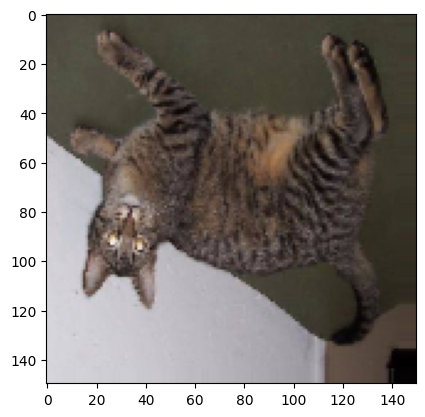

In [6]:
### test Generator
import matplotlib.pyplot as plt
import numpy as np
test_img = None
test_label = None
for image,label in test_gen:
    print(len(image))
    test_img = image
    test_label = label
    break
print(test_label[0])
print(test_img[0].shape)
plt.imshow(test_img[0])
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

input_shape = (img_size,img_size,3)
model = Sequential([
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same',input_shape = input_shape),
    MaxPool2D(pool_size = (2,2),strides=2),
   
    
    Conv2D(64,kernel_size=(3,3),activation = 'relu'),
    MaxPool2D(pool_size = (2,2),strides=2),

    Flatten(),
    Dense(512,activation = 'relu'),
    Dense(1,activation = 'sigmoid')    
    
])

/opt/anaconda3/envs/dev_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()
#tf.keras.utils.plot_model(model,show_shapes=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,487,745 (162.08 MB)

 Trainable params: 42,487,745 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import datetime

batch_size =  batch_size
epochs  = 3


base_learning_rate = 1e-3 #0.0001

from tensorflow.keras.optimizers import RMSprop


optimizer = tf.keras.optimizers.Adam()
#optimizer = RMSprop(learning_rate=0.0001)

#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
#model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])



In [10]:
num_train = len(train_gen.filenames)
num_test = len(test_gen.filenames)
steps_per_epoch=int(num_train / batch_size)
print("Number of train : ",num_train)
print(num_test/batch_size)
print(steps_per_epoch)

Number of train :  2752
15.5
172


In [11]:

# model signature
from mlflow.models import infer_signature
print("test_img shape : ",test_img.shape)
print("test_label shape : ",test_label.shape)



model_signature = infer_signature(test_img,model.predict(test_img))
print(model_signature)

test_img shape :  (16, 150, 150, 3)
test_label shape :  (16,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
inputs: 
  [Tensor('float32', (-1, 150, 150, 3))]
outputs: 
  [Tensor('float32', (-1, 1))]
params: 
  None



In [12]:
train_params = {
    "epochs" : epochs,
    "input_shape" : input_shape,
    "batch_size" : batch_size,
    "steps_per_epoch": steps_per_epoch,
    "base_learning_rate":base_learning_rate,
    
}

In [14]:
mlflow.tensorflow.autolog()
mlflow.enable_system_metrics_logging()

with mlflow.start_run(log_system_metrics = True) as run:
    mlflow.set_tag("developer","tharhtet")
    mlflow.log_params(train_params)

    
    history = model.fit(train_gen, epochs=epochs,
                                validation_data=test_gen,
                                verbose=1)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    final_valloss = 0 
    for t_acc,t_loss,v_acc,v_loss in zip(acc,loss,val_acc,loss):
        mlflow.log_metric("train_acc",t_acc)
        mlflow.log_metric("train_loss",t_loss)
        mlflow.log_metric("val_acc",v_acc)
        mlflow.log_metric("val_loss",v_loss)

    mlflow.keras.log_model(model,"cat_and_dog_model",signature=model_signature)
        

2024/09/22 11:30:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/09/22 11:30:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch 1/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.6227 - loss: 0.6420 - val_accuracy: 0.6532 - val_loss: 0.6167
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.6499 - loss: 0.6293 - val_accuracy: 0.6371 - val_loss: 0.6348
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.6532 - loss: 0.6196 - val_accuracy: 0.6411 - val_loss: 0.6356


2024/09/22 11:31:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged='[{'key': 'steps_per_epoch', 'old_value': '172', 'new_value': 'None'}]' for run ID='ec68b5996ecb4fc7b944cf17f4c5e75a'.
2024/09/22 11:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-eel-396 at: http://127.0.0.1:8888/#/experiments/2/runs/ec68b5996ecb4fc7b944cf17f4c5e75a.
2024/09/22 11:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8888/#/experiments/2.
2024/09/22 11:31:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/09/22 11:31:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


'ec68b5996ecb4fc7b944cf17f4c5e75a'

In [19]:
model_name = "ths_cat_and_dog_model"
model_uri = f'runs:/{run.info.run_id}/cat_and_dog_model'
model_version = mlflow.register_model(model_uri,model_name)
print("model_version : ",model_version)

Registered model 'ths_cat_and_dog_model' already exists. Creating a new version of this model...
2024/09/22 11:32:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ths_cat_and_dog_model, version 4


model_version :  <ModelVersion: aliases=[], creation_timestamp=1726979566241, current_stage='None', description='', last_updated_timestamp=1726979566241, name='ths_cat_and_dog_model', run_id='ec68b5996ecb4fc7b944cf17f4c5e75a', run_link='', source='mlflow-artifacts:/2/ec68b5996ecb4fc7b944cf17f4c5e75a/artifacts/cat_and_dog_model', status='READY', status_message='', tags={}, user_id='', version='4'>


Created version '4' of model 'ths_cat_and_dog_model'.


In [21]:
#add tag
from mlflow import MlflowClient
client = MlflowClient()
client.set_registered_model_alias(name=model_name,version=model_version.version,alias="prod_test")